# Experiment 004

This experiment aims to improve accuracy in the block landing model.

Possible reasons for low accuracy:
* The model doesn't have high enough capacity so it cannot model the appropriate function.
* The dataset is too small which leads to a lack of variety in the data.
* The model is stuck in a local minimum.
* The model is suffering from vanishing or exploding gradients.

Things we can try to improve the accuracy:
* (Done) Increase the model capacity
* (Done) Reduce the learning rate
* (Done) Vary the batch size
* (Done) Use batch normalization
* (Done) Get more training data
* Use momentum in the optimizer
* Make training data consist of 3 time steps instead of 2, so the model can "pre-empt" when a block is going to land.


In [1]:
import os
from pathlib import Path

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
class BlockLandingDataset(Dataset):
    def __init__(self, path: str):
        self.path = path
        if not os.path.exists(path):
            raise FileNotFoundError()
        with os.scandir(self.path) as it:
            entry: os.DirEntry = next(iter(it))
            _, self.ext = os.path.splitext(entry.name)
            self.highest_index = max((int(Path(file.path).stem) for file in it))

    def __len__(self):
        return self.highest_index + 1

    def __getitem__(self, idx):
        file = os.path.join(self.path, f"{idx}{self.ext}")
        if not os.path.exists(file):
            raise IndexError()
        boards = np.load(file)
        x = boards[:2] # Just take the first two frames as that's what will be input to the main model
        b1 = boards[1] # We can identify a block landing by the fact that a block spawns in the next time step
        b2 = boards[2]
        y = (np.all(b1[0] == 0) & np.any(b2[0] == 1)).astype(np.float32)
        x, y = torch.tensor(x), torch.tensor(y)
        return x, y
        

In [169]:
train_dataset = BlockLandingDataset(os.path.join("data", "block_landing", "train"))
test_dataset = BlockLandingDataset(os.path.join("data", "block_landing", "test"))
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)

x, y = next(iter(train_dataloader))
print(x.shape, x.dtype)
print(y.shape, y.dtype)

torch.Size([4, 2, 22, 10]) torch.int32
torch.Size([4]) torch.float32


In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [142]:
class BlockLandingModel(nn.Module):
    """Predicts whether a block has landed.

    Inputs:
        x: Tensor of int32 of shape (batch_size, seq_length, height, width). height = 22 and width = 10 are the dimensions of the game
           board. seq_length = 2 is the number of game board inputs. The entries should be 0 for empty cells and 1 for blocks.
    
    Returns: float32 scalar, logit for block landing prediction.
    """

    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(2, 5, 3)
        self.rnn = nn.GRU(5, 5)
        self.lin = nn.Linear(5, 1)

    def forward(self, x):
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((1, 0, 4, 2, 3)) # Move sequence to dimension 1 and channels/classes to dimension 2
        x1, x2 = x # Split up the two timesteps so we can apply convolution to them both separately
        x1 = F.relu(self.conv(F.pad(x1, (1, 1, 1, 1)))) # Pad height and width (the last 2 dimensions) with zeroes to represent the board boundaries
        x1 = F.avg_pool2d(x1, kernel_size=(22, 10)).squeeze(-1).squeeze(-1)
        x2 = F.relu(self.conv(F.pad(x2, (1, 1, 1, 1))))
        x2 = F.avg_pool2d(x2, kernel_size=(22, 10)).squeeze(-1).squeeze(-1)
        x = torch.concat((x1.unsqueeze(0), x2.unsqueeze(0)))
        x, rnn_state = self.rnn(x)
        x = x[-1] # Just take last predicted state
        logits = self.lin(x).squeeze(-1)
        return logits

In [6]:
model = BlockLandingModel().to(device)
print(model)

with torch.no_grad():
    X, y = next(iter(train_dataloader))
    logits = model(X)[0]
    preds = F.sigmoid(logits)
    print(f"Predicted states: {preds}")

BlockLandingModel(
  (conv): Conv2d(2, 5, kernel_size=(3, 3), stride=(1, 1))
  (rnn): GRU(5, 5)
  (lin): Linear(in_features=5, out_features=1, bias=True)
)
Predicted states: 0.5843791365623474


In [74]:
def train_loop(dataloader, model, loss_fn, optimizer):
    avg_loss = 0.0

    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss.item()

        if batch % 20 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    avg_loss /= size
    return avg_loss


def test_loop(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            classes = (pred >= 0).type(torch.float)
            correct += (classes == y).type(torch.float).mean().item()

    test_loss /= num_batches
    correct /= num_batches
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return {
        "loss": test_loss,
        "acc": correct,
    }

In [75]:
learning_rate = 1e-2
batch_size = 4
epochs = 30

model = BlockLandingModel().to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

loss_history = []
test_loss_history = []
test_acc_history = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    epoch_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    loss_history.append(epoch_loss)
    test_metrics = test_loop(test_dataloader, model, loss_fn)
    test_loss_history.append(test_metrics["loss"])
    test_acc_history.append(test_metrics["acc"])

print("Done!")

Epoch 1
-------------------------------
loss: 0.729077  [    4/  106]
loss: 0.666474  [   84/  106]
Test Error: 
 Accuracy: 57.1%, Avg loss: 0.686258 

Epoch 2
-------------------------------
loss: 0.694398  [    4/  106]
loss: 0.693665  [   84/  106]
Test Error: 
 Accuracy: 60.7%, Avg loss: 0.683788 

Epoch 3
-------------------------------
loss: 0.669383  [    4/  106]
loss: 0.712154  [   84/  106]
Test Error: 
 Accuracy: 64.3%, Avg loss: 0.682732 

Epoch 4
-------------------------------
loss: 0.655453  [    4/  106]
loss: 0.692809  [   84/  106]
Test Error: 
 Accuracy: 60.7%, Avg loss: 0.687379 

Epoch 5
-------------------------------
loss: 0.693255  [    4/  106]
loss: 0.684519  [   84/  106]
Test Error: 
 Accuracy: 60.7%, Avg loss: 0.688828 

Epoch 6
-------------------------------
loss: 0.683045  [    4/  106]
loss: 0.684498  [   84/  106]
Test Error: 
 Accuracy: 57.1%, Avg loss: 0.691216 

Epoch 7
-------------------------------
loss: 0.699363  [    4/  106]
loss: 0.692375  [ 

[]

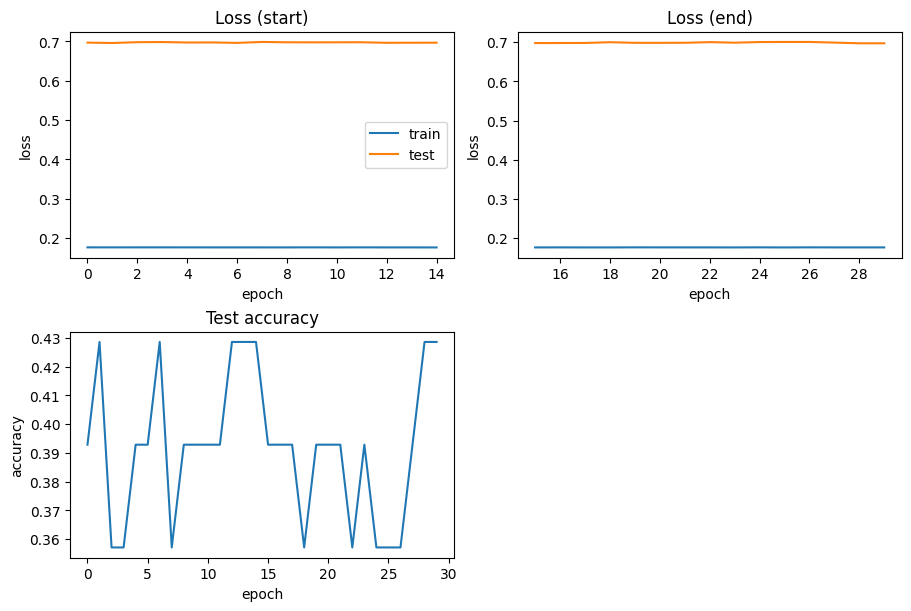

In [17]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(9, 6), constrained_layout=True)
axs = axs.flatten()
ax_loss_1, ax_loss_2, ax_acc, ax_blank = axs

ax_loss_1.plot(loss_history[:epochs//2], label="train")
ax_loss_1.plot(test_loss_history[:epochs//2], label="test")
ax_loss_1.set_title("Loss (start)")
ax_loss_1.set_xlabel("epoch")
ax_loss_1.set_ylabel("loss")
ax_loss_1.legend()

ax_loss_2.plot(list(range(epochs//2, epochs)), loss_history[epochs//2:], label="train")
ax_loss_2.plot(list(range(epochs//2, epochs)), test_loss_history[epochs//2:], label="test")
ax_loss_2.set_title("Loss (end)")
ax_loss_2.set_xlabel("epoch")
ax_loss_2.set_ylabel("loss")

ax_acc.plot(test_acc_history)
ax_acc.set_title("Test accuracy")
ax_acc.set_xlabel("epoch")
ax_acc.set_ylabel("accuracy")

ax_blank.set_visible(False)

plt.plot()

# Model capacity

Let's try to increase the model capacity so it can represent more complex functions.

In [18]:
class WiderModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(2, 10, 3)
        self.rnn = nn.GRU(10, 10)
        self.lin = nn.Linear(10, 1)

    def forward(self, x):
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((1, 0, 4, 2, 3)) # Move sequence to dimension 1 and channels/classes to dimension 2
        x1, x2 = x # Split up the two timesteps so we can apply convolution to them both separately
        x1 = F.relu(self.conv(F.pad(x1, (1, 1, 1, 1)))) # Pad height and width (the last 2 dimensions) with zeroes to represent the board boundaries
        x1 = F.avg_pool2d(x1, kernel_size=(22, 10)).squeeze(-1).squeeze(-1)
        x2 = F.relu(self.conv(F.pad(x2, (1, 1, 1, 1))))
        x2 = F.avg_pool2d(x2, kernel_size=(22, 10)).squeeze(-1).squeeze(-1)
        x = torch.concat((x1.unsqueeze(0), x2.unsqueeze(0)))
        x, rnn_state = self.rnn(x)
        x = x[-1] # Just take last predicted state
        logits = self.lin(x).squeeze(-1)
        return logits

In [19]:
class Extra3x3ConvModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(2, 5, 3)
        self.conv1 = nn.Conv2d(5, 5, 3)
        self.rnn = nn.GRU(5, 5)
        self.lin = nn.Linear(5, 1)

    def forward(self, x):
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((1, 0, 4, 2, 3)) # Move sequence to dimension 1 and channels/classes to dimension 2
        x1, x2 = x # Split up the two timesteps so we can apply convolution to them both separately

        x1 = F.relu(self.conv0(F.pad(x1, (1, 1, 1, 1)))) # Pad height and width (the last 2 dimensions) with zeroes to represent the board boundaries
        x1 = F.relu(self.conv1(F.pad(x1, (1, 1, 1, 1)))) # Pad height and width (the last 2 dimensions) with zeroes to represent the board boundaries
        x1 = F.avg_pool2d(x1, kernel_size=(22, 10)).squeeze(-1).squeeze(-1)

        x2 = F.relu(self.conv0(F.pad(x2, (1, 1, 1, 1))))
        x2 = F.relu(self.conv1(F.pad(x2, (1, 1, 1, 1))))
        x2 = F.avg_pool2d(x2, kernel_size=(22, 10)).squeeze(-1).squeeze(-1)

        x = torch.concat((x1.unsqueeze(0), x2.unsqueeze(0)))
        x, rnn_state = self.rnn(x)
        x = x[-1] # Just take last predicted state
        logits = self.lin(x).squeeze(-1)
        return logits

In [20]:
class Extra1x1ConvModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(2, 5, 3)
        self.conv1 = nn.Conv2d(5, 5, 1)
        self.rnn = nn.GRU(5, 5)
        self.lin = nn.Linear(5, 1)

    def forward(self, x):
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((1, 0, 4, 2, 3)) # Move sequence to dimension 1 and channels/classes to dimension 2
        x1, x2 = x # Split up the two timesteps so we can apply convolution to them both separately

        x1 = F.relu(self.conv0(F.pad(x1, (1, 1, 1, 1)))) # Pad height and width (the last 2 dimensions) with zeroes to represent the board boundaries
        x1 = F.relu(self.conv1(x1))
        x1 = F.avg_pool2d(x1, kernel_size=(22, 10)).squeeze(-1).squeeze(-1)

        x2 = F.relu(self.conv0(F.pad(x2, (1, 1, 1, 1))))
        x2 = F.relu(self.conv1(x2))
        x2 = F.avg_pool2d(x2, kernel_size=(22, 10)).squeeze(-1).squeeze(-1)

        x = torch.concat((x1.unsqueeze(0), x2.unsqueeze(0)))
        x, rnn_state = self.rnn(x)
        x = x[-1] # Just take last predicted state
        logits = self.lin(x).squeeze(-1)
        return logits

In [21]:
class ExtraLinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(2, 5, 3)
        self.rnn = nn.GRU(5, 5)
        self.lin0 = nn.Linear(5, 10)
        self.lin1 = nn.Linear(10, 1)

    def forward(self, x):
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((1, 0, 4, 2, 3)) # Move sequence to dimension 1 and channels/classes to dimension 2
        x1, x2 = x # Split up the two timesteps so we can apply convolution to them both separately
        x1 = F.relu(self.conv(F.pad(x1, (1, 1, 1, 1)))) # Pad height and width (the last 2 dimensions) with zeroes to represent the board boundaries
        x1 = F.avg_pool2d(x1, kernel_size=(22, 10)).squeeze(-1).squeeze(-1)
        x2 = F.relu(self.conv(F.pad(x2, (1, 1, 1, 1))))
        x2 = F.avg_pool2d(x2, kernel_size=(22, 10)).squeeze(-1).squeeze(-1)
        x = torch.concat((x1.unsqueeze(0), x2.unsqueeze(0)))
        x, rnn_state = self.rnn(x)
        x = x[-1] # Just take last predicted state
        x = F.relu(self.lin0(x))
        logits = self.lin1(x).squeeze(-1)
        return logits

In [32]:
class LinearBeforeRnnModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(2, 5, 3)
        self.lin0 = nn.Linear(5, 5)
        self.rnn = nn.GRU(5, 5)
        self.lin1 = nn.Linear(5, 1)

    def forward(self, x):
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((1, 0, 4, 2, 3)) # Move sequence to dimension 1 and channels/classes to dimension 2
        x1, x2 = x # Split up the two timesteps so we can apply convolution to them both separately
        x1 = F.relu(self.conv(F.pad(x1, (1, 1, 1, 1)))) # Pad height and width (the last 2 dimensions) with zeroes to represent the board boundaries
        x1 = F.avg_pool2d(x1, kernel_size=(22, 10)).squeeze(-1).squeeze(-1)
        x2 = F.relu(self.conv(F.pad(x2, (1, 1, 1, 1))))
        x2 = F.avg_pool2d(x2, kernel_size=(22, 10)).squeeze(-1).squeeze(-1)
        x = torch.concat((x1.unsqueeze(0), x2.unsqueeze(0)))
        x = F.relu(self.lin0(x))
        x, rnn_state = self.rnn(x)
        x = x[-1] # Just take last predicted state
        logits = self.lin1(x).squeeze(-1)
        return logits

Model 'baseline' has 281 parameters.
Model 'wider' has 861 parameters.
Model 'extra 3x3 conv' has 511 parameters.
Model 'extra 1x1 conv' has 311 parameters.
Model 'extra linear layer' has 346 parameters.
Model 'linear before rnn' has 311 parameters.
Training model 'baseline'...
Epoch 1
-------------------------------
loss: 0.693441  [    4/  106]
loss: 0.686812  [   84/  106]
Test Error: 
 Accuracy: 57.1%, Avg loss: 0.691508 

Epoch 2
-------------------------------
loss: 0.693449  [    4/  106]
loss: 0.698431  [   84/  106]
Test Error: 
 Accuracy: 64.3%, Avg loss: 0.690134 

Epoch 3
-------------------------------
loss: 0.686921  [    4/  106]
loss: 0.692857  [   84/  106]
Test Error: 
 Accuracy: 60.7%, Avg loss: 0.691008 

Epoch 4
-------------------------------
loss: 0.697202  [    4/  106]
loss: 0.682565  [   84/  106]
Test Error: 
 Accuracy: 64.3%, Avg loss: 0.690663 

Epoch 5
-------------------------------
loss: 0.692782  [    4/  106]
loss: 0.697704  [   84/  106]
Test Error: 


[]

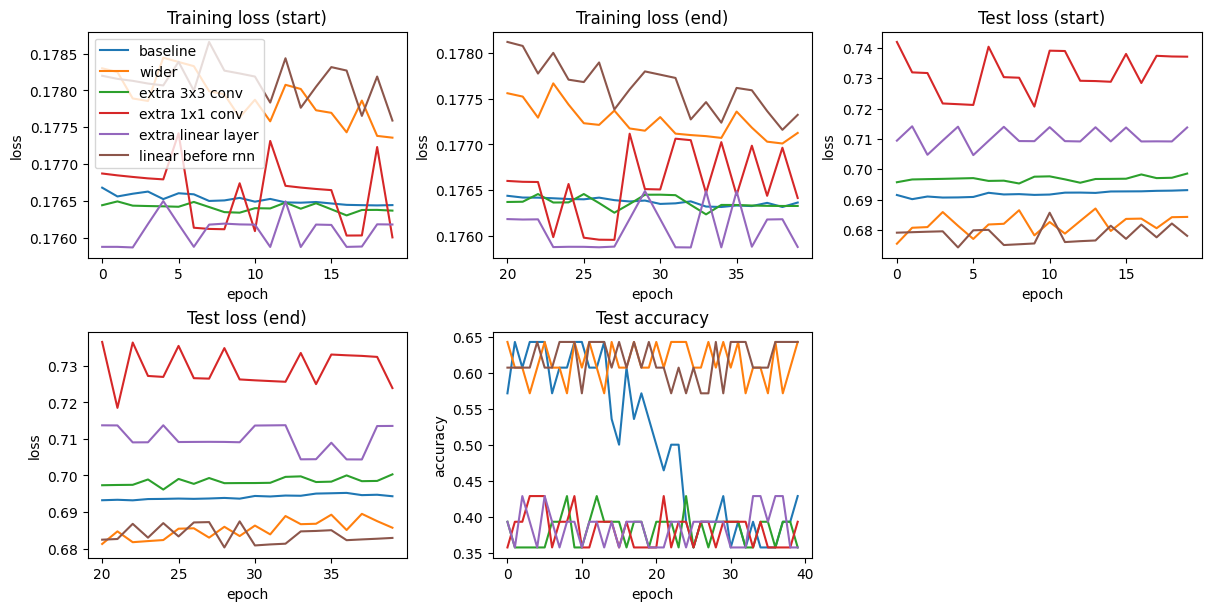

In [37]:
learning_rate = 1e-3
batch_size = 4
epochs = 40

models = {
    "baseline": BlockLandingModel().to(device),
    "wider": WiderModel().to(device),
    "extra 3x3 conv": Extra3x3ConvModel().to(device),
    "extra 1x1 conv": Extra1x1ConvModel().to(device),
    "extra linear layer": ExtraLinearModel().to(device),
    "linear before rnn": LinearBeforeRnnModel().to(device)
}

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

for name, model in models.items():
    print(f"Model '{name}' has {count_parameters(model)} parameters.")

fig, axs = plt.subplots(2, 3, figsize=(12, 6), constrained_layout=True)
axs = axs.flatten()
ax_loss_1, ax_loss_2, ax_test_loss_1, ax_test_loss_2, ax_acc, ax_blank = axs

for name, model in models.items():
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    loss_history = []
    test_loss_history = []
    test_acc_history = []

    print(f"Training model '{name}'...")
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        epoch_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
        loss_history.append(epoch_loss)
        test_metrics = test_loop(test_dataloader, model, loss_fn)
        test_loss_history.append(test_metrics["loss"])
        test_acc_history.append(test_metrics["acc"])
    print("Done!")

    ax_loss_1.plot(loss_history[:epochs//2], label=name)
    ax_loss_2.plot(list(range(epochs//2, epochs)), loss_history[epochs//2:], label=name)
    ax_test_loss_1.plot(test_loss_history[:epochs//2], label=name)
    ax_test_loss_2.plot(list(range(epochs//2, epochs)), test_loss_history[epochs//2:], label=name)
    ax_acc.plot(test_acc_history, label=name)


ax_loss_1.set_title("Training loss (start)")
ax_loss_1.set_xlabel("epoch")
ax_loss_1.set_ylabel("loss")
ax_loss_1.legend()

ax_loss_2.set_title("Training loss (end)")
ax_loss_2.set_xlabel("epoch")
ax_loss_2.set_ylabel("loss")

ax_test_loss_1.set_title("Test loss (start)")
ax_test_loss_1.set_xlabel("epoch")
ax_test_loss_1.set_ylabel("loss")

ax_test_loss_2.set_title("Test loss (end)")
ax_test_loss_2.set_xlabel("epoch")
ax_test_loss_2.set_ylabel("loss")

ax_acc.set_title("Test accuracy")
ax_acc.set_xlabel("epoch")
ax_acc.set_ylabel("accuracy")

ax_blank.set_visible(False)

plt.plot()

In the training process above, we tried multiple model architectures against each other but also reduced the learning rate from 1e-2 to 1e-3 as it seemed to improve accuracy for some models and reduce training instability for all models.

There is no clear winner here between the architectures, and in fact the best performing model tends to change randomly as we re-run the training.

# Learning rate

Let's now experiment with different learning rates.

Training model with learning rate 0.01...
Epoch 1
-------------------------------
loss: 0.618217  [    4/  106]
loss: 0.710517  [   84/  106]
Test Error: 
 Accuracy: 42.9%, Avg loss: 0.732341 

Epoch 2
-------------------------------
loss: 0.706771  [    4/  106]
loss: 0.626553  [   84/  106]
Test Error: 
 Accuracy: 39.3%, Avg loss: 0.739095 

Epoch 3
-------------------------------
loss: 0.628485  [    4/  106]
loss: 0.630616  [   84/  106]
Test Error: 
 Accuracy: 35.7%, Avg loss: 0.745402 

Epoch 4
-------------------------------
loss: 0.782413  [    4/  106]
loss: 0.633737  [   84/  106]
Test Error: 
 Accuracy: 35.7%, Avg loss: 0.741328 

Epoch 5
-------------------------------
loss: 0.708258  [    4/  106]
loss: 0.771210  [   84/  106]
Test Error: 
 Accuracy: 35.7%, Avg loss: 0.737106 

Epoch 6
-------------------------------
loss: 0.643501  [    4/  106]
loss: 0.767090  [   84/  106]
Test Error: 
 Accuracy: 35.7%, Avg loss: 0.733838 

Epoch 7
-------------------------------
loss: 

[]

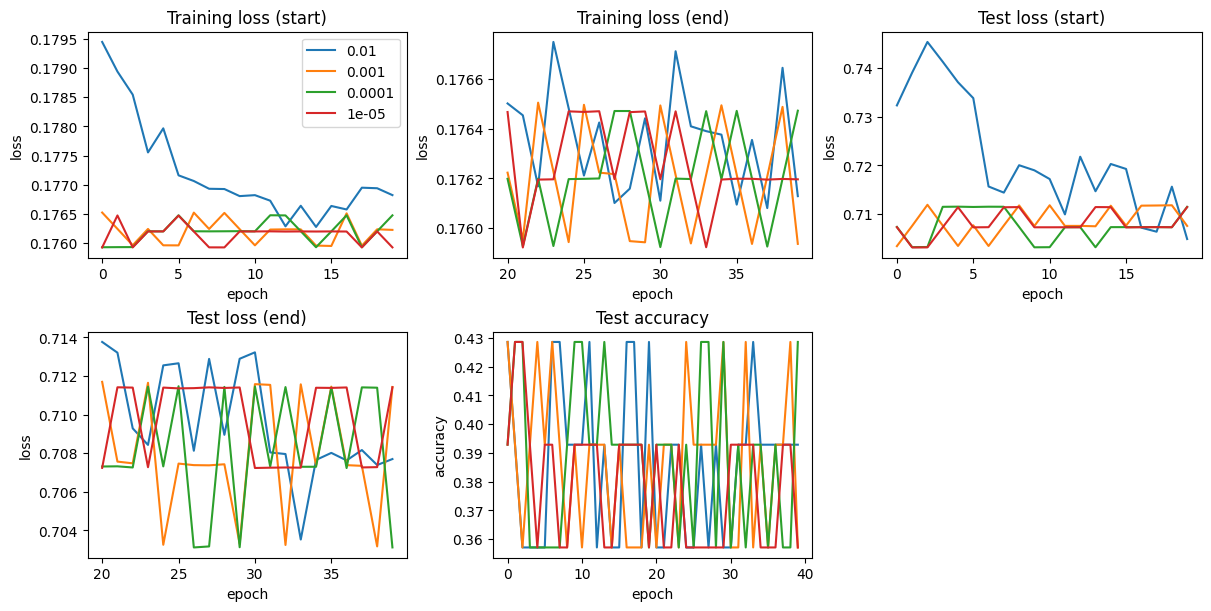

In [36]:
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]
batch_size = 4
epochs = 40

model = BlockLandingModel().to(device)

fig, axs = plt.subplots(2, 3, figsize=(12, 6), constrained_layout=True)
axs = axs.flatten()
ax_loss_1, ax_loss_2, ax_test_loss_1, ax_test_loss_2, ax_acc, ax_blank = axs

for learning_rate in learning_rates:
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    loss_history = []
    test_loss_history = []
    test_acc_history = []

    print(f"Training model with learning rate {learning_rate}...")
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        epoch_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
        loss_history.append(epoch_loss)
        test_metrics = test_loop(test_dataloader, model, loss_fn)
        test_loss_history.append(test_metrics["loss"])
        test_acc_history.append(test_metrics["acc"])
    print("Done!")

    ax_loss_1.plot(loss_history[:epochs//2], label=str(learning_rate))
    ax_loss_2.plot(list(range(epochs//2, epochs)), loss_history[epochs//2:], label=str(learning_rate))
    ax_test_loss_1.plot(test_loss_history[:epochs//2], label=str(learning_rate))
    ax_test_loss_2.plot(list(range(epochs//2, epochs)), test_loss_history[epochs//2:], label=str(learning_rate))
    ax_acc.plot(test_acc_history, label=str(learning_rate))


ax_loss_1.set_title("Training loss (start)")
ax_loss_1.set_xlabel("epoch")
ax_loss_1.set_ylabel("loss")
ax_loss_1.legend()

ax_loss_2.set_title("Training loss (end)")
ax_loss_2.set_xlabel("epoch")
ax_loss_2.set_ylabel("loss")

ax_test_loss_1.set_title("Test loss (start)")
ax_test_loss_1.set_xlabel("epoch")
ax_test_loss_1.set_ylabel("loss")

ax_test_loss_2.set_title("Test loss (end)")
ax_test_loss_2.set_xlabel("epoch")
ax_test_loss_2.set_ylabel("loss")

ax_acc.set_title("Test accuracy")
ax_acc.set_xlabel("epoch")
ax_acc.set_ylabel("accuracy")

ax_blank.set_visible(False)

plt.plot()

The different learning rates don't seem to make much difference.

# Batch size

Let's vary the batch size and see if that helps the situation

Training model with batch size 2...
Epoch 1
-------------------------------
loss: 0.692387  [    2/  106]
loss: 0.698026  [   42/  106]
loss: 0.695339  [   82/  106]
Test Error: 
 Accuracy: 38.5%, Avg loss: 0.705576 

Epoch 2
-------------------------------
loss: 0.647723  [    2/  106]
loss: 0.694784  [   42/  106]
loss: 0.694382  [   82/  106]
Test Error: 
 Accuracy: 38.5%, Avg loss: 0.706799 

Epoch 3
-------------------------------
loss: 0.694928  [    2/  106]
loss: 0.665645  [   42/  106]
loss: 0.695395  [   82/  106]
Test Error: 
 Accuracy: 38.5%, Avg loss: 0.707429 

Epoch 4
-------------------------------
loss: 0.638278  [    2/  106]
loss: 0.694067  [   42/  106]
loss: 0.696488  [   82/  106]
Test Error: 
 Accuracy: 38.5%, Avg loss: 0.707161 

Epoch 5
-------------------------------
loss: 0.641335  [    2/  106]
loss: 0.695318  [   42/  106]
loss: 0.630254  [   82/  106]
Test Error: 
 Accuracy: 38.5%, Avg loss: 0.706402 

Epoch 6
-------------------------------
loss: 0.643752

[]

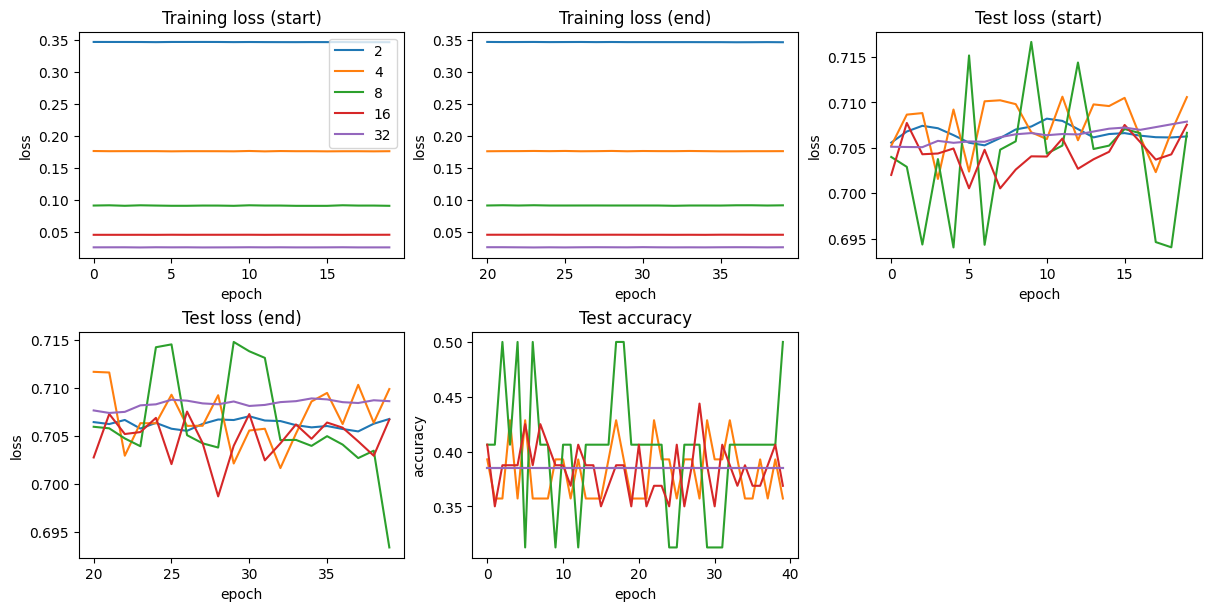

In [39]:
learning_rate = 1e-2
batch_sizes = [2, 4, 8, 16, 32]
epochs = 40

model = BlockLandingModel().to(device)

fig, axs = plt.subplots(2, 3, figsize=(12, 6), constrained_layout=True)
axs = axs.flatten()
ax_loss_1, ax_loss_2, ax_test_loss_1, ax_test_loss_2, ax_acc, ax_blank = axs

for batch_size in batch_sizes:
    train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    loss_history = []
    test_loss_history = []
    test_acc_history = []

    print(f"Training model with batch size {batch_size}...")
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        epoch_loss = train_loop(train_dl, model, loss_fn, optimizer)
        loss_history.append(epoch_loss)
        test_metrics = test_loop(test_dl, model, loss_fn)
        test_loss_history.append(test_metrics["loss"])
        test_acc_history.append(test_metrics["acc"])
    print("Done!")

    ax_loss_1.plot(loss_history[:epochs//2], label=str(batch_size))
    ax_loss_2.plot(list(range(epochs//2, epochs)), loss_history[epochs//2:], label=str(batch_size))
    ax_test_loss_1.plot(test_loss_history[:epochs//2], label=str(batch_size))
    ax_test_loss_2.plot(list(range(epochs//2, epochs)), test_loss_history[epochs//2:], label=str(batch_size))
    ax_acc.plot(test_acc_history, label=str(batch_size))


ax_loss_1.set_title("Training loss (start)")
ax_loss_1.set_xlabel("epoch")
ax_loss_1.set_ylabel("loss")
ax_loss_1.legend()

ax_loss_2.set_title("Training loss (end)")
ax_loss_2.set_xlabel("epoch")
ax_loss_2.set_ylabel("loss")

ax_test_loss_1.set_title("Test loss (start)")
ax_test_loss_1.set_xlabel("epoch")
ax_test_loss_1.set_ylabel("loss")

ax_test_loss_2.set_title("Test loss (end)")
ax_test_loss_2.set_xlabel("epoch")
ax_test_loss_2.set_ylabel("loss")

ax_acc.set_title("Test accuracy")
ax_acc.set_xlabel("epoch")
ax_acc.set_ylabel("accuracy")

ax_blank.set_visible(False)

plt.plot()

A batch size of 32 clearly appears to give the most stable training, even though it doesn't improve the accuracy at all. All the batch sizes oscillate around the same test loss and test accuracy.

# Batch normalization

Let's see if batch normalization improves anything.

In [43]:
class BatchNormBeforeRnnModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(2, 5, 3)
        self.norm = nn.BatchNorm1d(5)
        self.rnn = nn.GRU(5, 5)
        self.lin = nn.Linear(5, 1)

    def forward(self, x):
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((1, 0, 4, 2, 3)) # Move sequence to dimension 1 and channels/classes to dimension 2
        x1, x2 = x # Split up the two timesteps so we can apply convolution to them both separately

        x1 = F.relu(self.conv(F.pad(x1, (1, 1, 1, 1)))) # Pad height and width (the last 2 dimensions) with zeroes to represent the board boundaries
        x1 = F.avg_pool2d(x1, kernel_size=(22, 10)).squeeze(-1).squeeze(-1)
        x1 = self.norm(x1)

        x2 = F.relu(self.conv(F.pad(x2, (1, 1, 1, 1))))
        x2 = F.avg_pool2d(x2, kernel_size=(22, 10)).squeeze(-1).squeeze(-1)
        x2 = self.norm(x2)

        x = torch.concat((x1.unsqueeze(0), x2.unsqueeze(0)))
        x, rnn_state = self.rnn(x)
        x = x[-1] # Just take last predicted state
        logits = self.lin(x).squeeze(-1)
        return logits

In [44]:
class BatchNormAfterRnnModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(2, 5, 3)
        self.rnn = nn.GRU(5, 5)
        self.norm = nn.BatchNorm1d(5)
        self.lin = nn.Linear(5, 1)

    def forward(self, x):
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((1, 0, 4, 2, 3)) # Move sequence to dimension 1 and channels/classes to dimension 2
        x1, x2 = x # Split up the two timesteps so we can apply convolution to them both separately

        x1 = F.relu(self.conv(F.pad(x1, (1, 1, 1, 1)))) # Pad height and width (the last 2 dimensions) with zeroes to represent the board boundaries
        x1 = F.avg_pool2d(x1, kernel_size=(22, 10)).squeeze(-1).squeeze(-1)

        x2 = F.relu(self.conv(F.pad(x2, (1, 1, 1, 1))))
        x2 = F.avg_pool2d(x2, kernel_size=(22, 10)).squeeze(-1).squeeze(-1)

        x = torch.concat((x1.unsqueeze(0), x2.unsqueeze(0)))
        x, rnn_state = self.rnn(x)
        x = x[-1] # Just take last predicted state
        x = self.norm(x)
        logits = self.lin(x).squeeze(-1)
        return logits

In [45]:
class BatchNormBothModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(2, 5, 3)
        self.norm0 = nn.BatchNorm1d(5)
        self.rnn = nn.GRU(5, 5)
        self.norm1 = nn.BatchNorm1d(5)
        self.lin = nn.Linear(5, 1)

    def forward(self, x):
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((1, 0, 4, 2, 3)) # Move sequence to dimension 1 and channels/classes to dimension 2
        x1, x2 = x # Split up the two timesteps so we can apply convolution to them both separately

        x1 = F.relu(self.conv(F.pad(x1, (1, 1, 1, 1)))) # Pad height and width (the last 2 dimensions) with zeroes to represent the board boundaries
        x1 = F.avg_pool2d(x1, kernel_size=(22, 10)).squeeze(-1).squeeze(-1)
        x1 = self.norm0(x1)

        x2 = F.relu(self.conv(F.pad(x2, (1, 1, 1, 1))))
        x2 = F.avg_pool2d(x2, kernel_size=(22, 10)).squeeze(-1).squeeze(-1)
        x2 = self.norm0(x2)

        x = torch.concat((x1.unsqueeze(0), x2.unsqueeze(0)))
        x, rnn_state = self.rnn(x)
        x = x[-1] # Just take last predicted state
        x = self.norm1(x)
        logits = self.lin(x).squeeze(-1)
        return logits

Training model 'baseline'...
Epoch 1
-------------------------------
loss: 0.669431  [    4/  106]
loss: 0.671416  [   84/  106]
Test Error: 
 Accuracy: 42.9%, Avg loss: 0.702787 

Epoch 2
-------------------------------
loss: 0.670148  [    4/  106]
loss: 0.696178  [   84/  106]
Test Error: 
 Accuracy: 39.3%, Avg loss: 0.705550 

Epoch 3
-------------------------------
loss: 0.697155  [    4/  106]
loss: 0.694129  [   84/  106]
Test Error: 
 Accuracy: 42.9%, Avg loss: 0.701682 

Epoch 4
-------------------------------
loss: 0.669016  [    4/  106]
loss: 0.666990  [   84/  106]
Test Error: 
 Accuracy: 42.9%, Avg loss: 0.700953 

Epoch 5
-------------------------------
loss: 0.695768  [    4/  106]
loss: 0.677887  [   84/  106]
Test Error: 
 Accuracy: 39.3%, Avg loss: 0.704354 

Epoch 6
-------------------------------
loss: 0.720702  [    4/  106]
loss: 0.695179  [   84/  106]
Test Error: 
 Accuracy: 42.9%, Avg loss: 0.701091 

Epoch 7
-------------------------------
loss: 0.695814  [  

[]

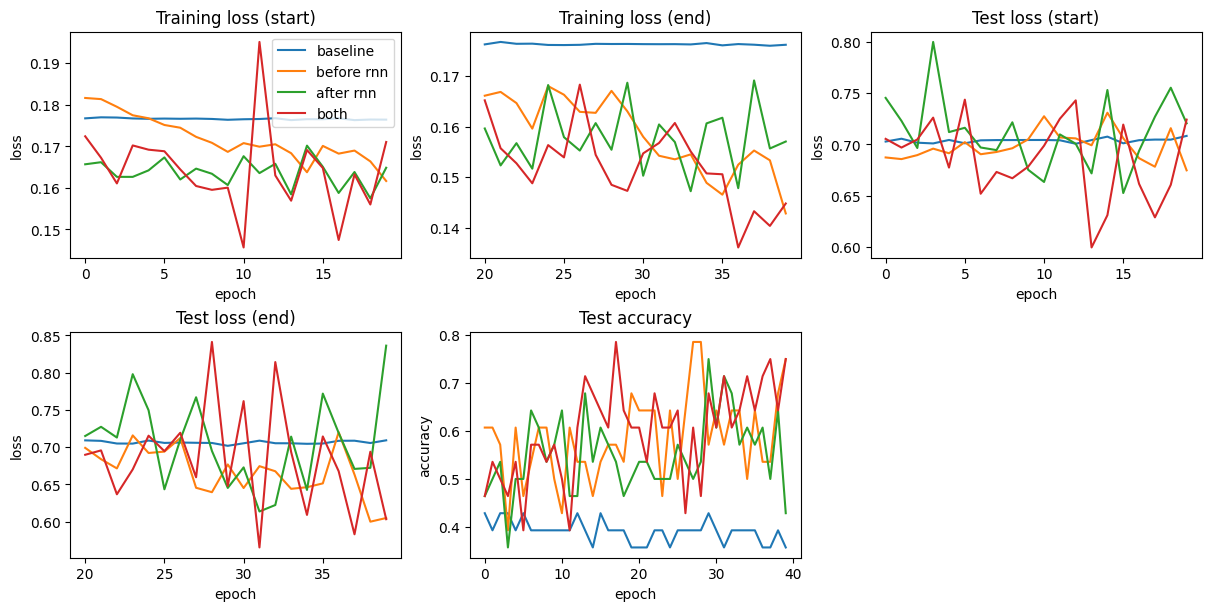

In [49]:
learning_rate = 1e-2
batch_size = 4
epochs = 40

models = {
    "baseline": BlockLandingModel().to(device),
    "before rnn": BatchNormBeforeRnnModel().to(device),
    "after rnn": BatchNormAfterRnnModel().to(device),
    "both": BatchNormBothModel().to(device),
}

fig, axs = plt.subplots(2, 3, figsize=(12, 6), constrained_layout=True)
axs = axs.flatten()
ax_loss_1, ax_loss_2, ax_test_loss_1, ax_test_loss_2, ax_acc, ax_blank = axs

for name, model in models.items():
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    loss_history = []
    test_loss_history = []
    test_acc_history = []

    print(f"Training model '{name}'...")
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        epoch_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
        loss_history.append(epoch_loss)
        test_metrics = test_loop(test_dataloader, model, loss_fn)
        test_loss_history.append(test_metrics["loss"])
        test_acc_history.append(test_metrics["acc"])
    print("Done!")

    ax_loss_1.plot(loss_history[:epochs//2], label=name)
    ax_loss_2.plot(list(range(epochs//2, epochs)), loss_history[epochs//2:], label=name)
    ax_test_loss_1.plot(test_loss_history[:epochs//2], label=name)
    ax_test_loss_2.plot(list(range(epochs//2, epochs)), test_loss_history[epochs//2:], label=name)
    ax_acc.plot(test_acc_history, label=name)


ax_loss_1.set_title("Training loss (start)")
ax_loss_1.set_xlabel("epoch")
ax_loss_1.set_ylabel("loss")
ax_loss_1.legend()

ax_loss_2.set_title("Training loss (end)")
ax_loss_2.set_xlabel("epoch")
ax_loss_2.set_ylabel("loss")

ax_test_loss_1.set_title("Test loss (start)")
ax_test_loss_1.set_xlabel("epoch")
ax_test_loss_1.set_ylabel("loss")

ax_test_loss_2.set_title("Test loss (end)")
ax_test_loss_2.set_xlabel("epoch")
ax_test_loss_2.set_ylabel("loss")

ax_acc.set_title("Test accuracy")
ax_acc.set_xlabel("epoch")
ax_acc.set_ylabel("accuracy")

ax_blank.set_visible(False)

plt.plot()

Batch normalization certainly does seem to improve accuracy here, but it also makes the training more unstable. Having batch normalization after the RNN part seems to help the most, but the exact ranking of the two models with this property seems to vary each time we re-run the training.

# Dataset size

To try and measure the effect of dataset size while keeping the investigation contained to just this notebook, we will make a Dataset object that purposefully skips some of the data. If the model performance degrades significantly with less training data, this is a good sign that the model would work better with more data.

In [57]:
class ReducedDataset(Dataset):
    def __init__(self, dataset: Dataset, fraction: float, shift=0):
        self.dataset = dataset
        if fraction <= 0.0 or fraction > 1.0:
            raise ValueError("Fraction must be greater than 0.0 and at most 1.0.")
        self.fraction = fraction
        if shift < 0:
            raise ValueError("Shift must be positive or zero.")
        self.shift = shift

    def __len__(self):
        return int(len(self.dataset) * self.fraction)

    def __getitem__(self, idx):
        idx = int(idx / self.fraction)
        idx = idx + self.shift
        idx = idx % len(self.dataset)
        return self.dataset[idx]
        

Training model with dataset '100%'...
Epoch 1
-------------------------------
loss: 0.695461  [    4/  106]
loss: 0.656665  [   84/  106]
Test Error: 
 Accuracy: 35.7%, Avg loss: 0.716535 

Epoch 2
-------------------------------
loss: 0.695901  [    4/  106]
loss: 0.694641  [   84/  106]
Test Error: 
 Accuracy: 42.9%, Avg loss: 0.705297 

Epoch 3
-------------------------------
loss: 0.695639  [    4/  106]
loss: 0.724351  [   84/  106]
Test Error: 
 Accuracy: 35.7%, Avg loss: 0.715673 

Epoch 4
-------------------------------
loss: 0.694322  [    4/  106]
loss: 0.693637  [   84/  106]
Test Error: 
 Accuracy: 35.7%, Avg loss: 0.715751 

Epoch 5
-------------------------------
loss: 0.729732  [    4/  106]
loss: 0.726778  [   84/  106]
Test Error: 
 Accuracy: 39.3%, Avg loss: 0.710367 

Epoch 6
-------------------------------
loss: 0.729865  [    4/  106]
loss: 0.661888  [   84/  106]
Test Error: 
 Accuracy: 39.3%, Avg loss: 0.710194 

Epoch 7
-------------------------------
loss: 0.65

[]

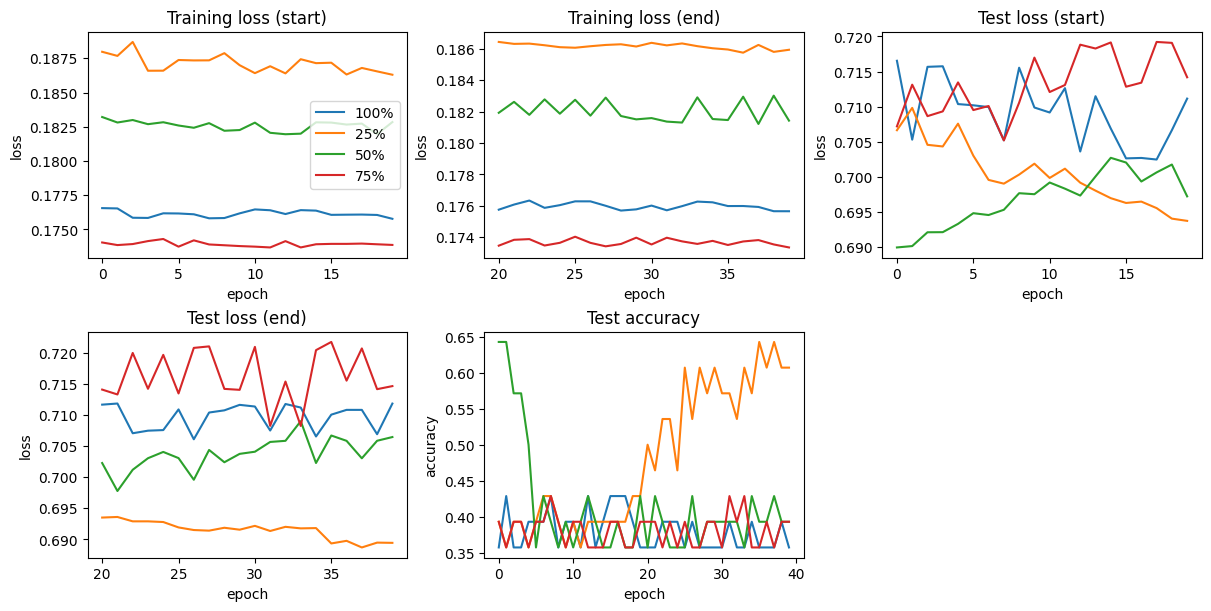

In [59]:
learning_rate = 1e-2
batch_size = 4
epochs = 40

model = BlockLandingModel().to(device)

datasets = {
    "100%": train_dataset,
    "25%": ReducedDataset(train_dataset, 0.25),
    "50%": ReducedDataset(train_dataset, 0.5),
    "75%": ReducedDataset(train_dataset, 0.75),
}

fig, axs = plt.subplots(2, 3, figsize=(12, 6), constrained_layout=True)
axs = axs.flatten()
ax_loss_1, ax_loss_2, ax_test_loss_1, ax_test_loss_2, ax_acc, ax_blank = axs

for name, train_ds in datasets.items():
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    loss_history = []
    test_loss_history = []
    test_acc_history = []

    print(f"Training model with dataset '{name}'...")
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        epoch_loss = train_loop(train_dl, model, loss_fn, optimizer)
        loss_history.append(epoch_loss)
        test_metrics = test_loop(test_dataloader, model, loss_fn)
        test_loss_history.append(test_metrics["loss"])
        test_acc_history.append(test_metrics["acc"])
    print("Done!")

    ax_loss_1.plot(loss_history[:epochs//2], label=name)
    ax_loss_2.plot(list(range(epochs//2, epochs)), loss_history[epochs//2:], label=name)
    ax_test_loss_1.plot(test_loss_history[:epochs//2], label=name)
    ax_test_loss_2.plot(list(range(epochs//2, epochs)), test_loss_history[epochs//2:], label=name)
    ax_acc.plot(test_acc_history, label=name)


ax_loss_1.set_title("Training loss (start)")
ax_loss_1.set_xlabel("epoch")
ax_loss_1.set_ylabel("loss")
ax_loss_1.legend()

ax_loss_2.set_title("Training loss (end)")
ax_loss_2.set_xlabel("epoch")
ax_loss_2.set_ylabel("loss")

ax_test_loss_1.set_title("Test loss (start)")
ax_test_loss_1.set_xlabel("epoch")
ax_test_loss_1.set_ylabel("loss")

ax_test_loss_2.set_title("Test loss (end)")
ax_test_loss_2.set_xlabel("epoch")
ax_test_loss_2.set_ylabel("loss")

ax_acc.set_title("Test accuracy")
ax_acc.set_xlabel("epoch")
ax_acc.set_ylabel("accuracy")

ax_blank.set_visible(False)

plt.plot()

The dataset size doesn't seem to have much of an impact on accuracy. Interestingly, using only 25% of the data actually gives the best test accuracy. Let's do another test where we shift the 25% subset of data used, to make sure this isn't just a random fluke due to the 25% subset matching the test set more closely.

Training model with dataset '100%'...
Epoch 1
-------------------------------
loss: 0.693278  [    4/  106]
loss: 0.693282  [   84/  106]
Test Error: 
 Accuracy: 60.7%, Avg loss: 0.690873 

Epoch 2
-------------------------------
loss: 0.687881  [    4/  106]
loss: 0.703956  [   84/  106]
Test Error: 
 Accuracy: 60.7%, Avg loss: 0.692321 

Epoch 3
-------------------------------
loss: 0.693290  [    4/  106]
loss: 0.693740  [   84/  106]
Test Error: 
 Accuracy: 35.7%, Avg loss: 0.693876 

Epoch 4
-------------------------------
loss: 0.692913  [    4/  106]
loss: 0.693584  [   84/  106]
Test Error: 
 Accuracy: 35.7%, Avg loss: 0.696130 

Epoch 5
-------------------------------
loss: 0.693320  [    4/  106]
loss: 0.693208  [   84/  106]
Test Error: 
 Accuracy: 39.3%, Avg loss: 0.696401 

Epoch 6
-------------------------------
loss: 0.685866  [    4/  106]
loss: 0.693569  [   84/  106]
Test Error: 
 Accuracy: 35.7%, Avg loss: 0.699425 

Epoch 7
-------------------------------
loss: 0.70

[]

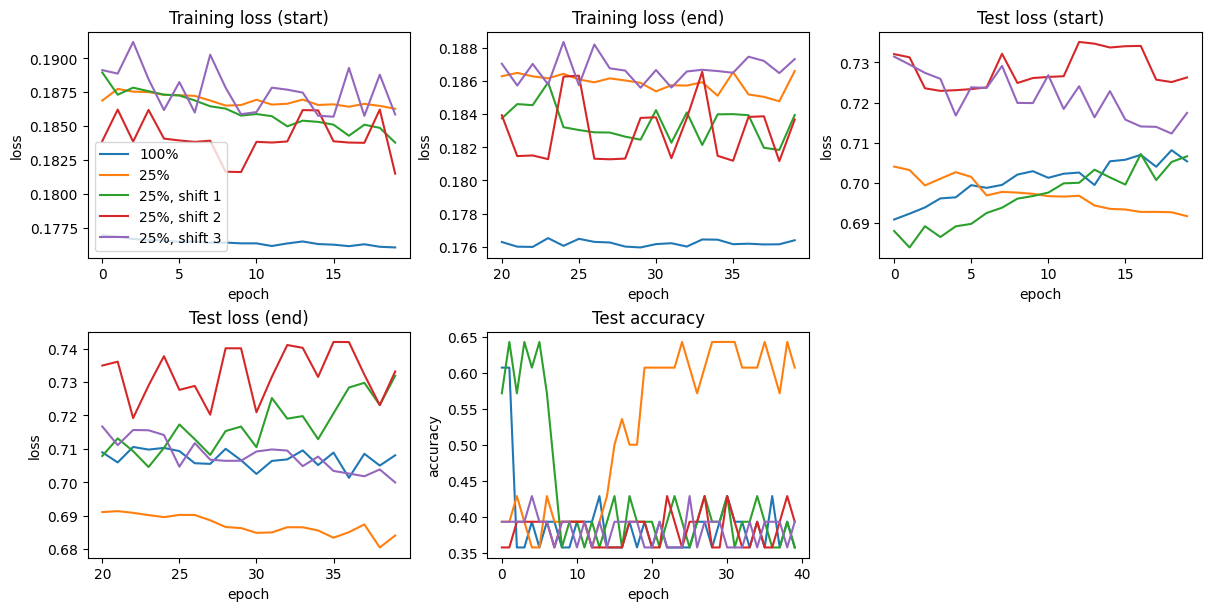

In [62]:
learning_rate = 1e-2
batch_size = 4
epochs = 40

model = BlockLandingModel().to(device)

datasets = {
    "100%": train_dataset,
    "25%": ReducedDataset(train_dataset, 0.25),
    "25%, shift 1": ReducedDataset(train_dataset, 0.25, shift=1),
    "25%, shift 2": ReducedDataset(train_dataset, 0.25, shift=2),
    "25%, shift 3": ReducedDataset(train_dataset, 0.25, shift=3),
}

fig, axs = plt.subplots(2, 3, figsize=(12, 6), constrained_layout=True)
axs = axs.flatten()
ax_loss_1, ax_loss_2, ax_test_loss_1, ax_test_loss_2, ax_acc, ax_blank = axs

for name, train_ds in datasets.items():
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    loss_history = []
    test_loss_history = []
    test_acc_history = []

    print(f"Training model with dataset '{name}'...")
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        epoch_loss = train_loop(train_dl, model, loss_fn, optimizer)
        loss_history.append(epoch_loss)
        test_metrics = test_loop(test_dataloader, model, loss_fn)
        test_loss_history.append(test_metrics["loss"])
        test_acc_history.append(test_metrics["acc"])
    print("Done!")

    ax_loss_1.plot(loss_history[:epochs//2], label=name)
    ax_loss_2.plot(list(range(epochs//2, epochs)), loss_history[epochs//2:], label=name)
    ax_test_loss_1.plot(test_loss_history[:epochs//2], label=name)
    ax_test_loss_2.plot(list(range(epochs//2, epochs)), test_loss_history[epochs//2:], label=name)
    ax_acc.plot(test_acc_history, label=name)


ax_loss_1.set_title("Training loss (start)")
ax_loss_1.set_xlabel("epoch")
ax_loss_1.set_ylabel("loss")
ax_loss_1.legend()

ax_loss_2.set_title("Training loss (end)")
ax_loss_2.set_xlabel("epoch")
ax_loss_2.set_ylabel("loss")

ax_test_loss_1.set_title("Test loss (start)")
ax_test_loss_1.set_xlabel("epoch")
ax_test_loss_1.set_ylabel("loss")

ax_test_loss_2.set_title("Test loss (end)")
ax_test_loss_2.set_xlabel("epoch")
ax_test_loss_2.set_ylabel("loss")

ax_acc.set_title("Test accuracy")
ax_acc.set_xlabel("epoch")
ax_acc.set_ylabel("accuracy")

ax_blank.set_visible(False)

plt.plot()

The unshifted subset consistently gets higher accuracy towards the end of the training run. The shift 1 subset consistently gets higher accuracy towards the start of the training run. The other two shifted subsets have low test accuracy throughout. This suggests that the high accuracy seen in the unshifted 25% subset is just a fluke.

From these results, we have no solid evidence that increasing dataset size would improve model performance. It may nevertheless be advantageous to do so.

# Gradients

Let's look at the gradients to see if we are experiencing vanishing/exploding gradients.

In [148]:
def train_loop_with_gradients(dataloader, model, loss_fn, optimizer):
    avg_loss = 0.0
    grads = {
        "conv_w": 0.0,
        "conv_b": 0.0,
        "rnn_w0": 0.0,
        "rnn_w1": 0.0,
        "rnn_b0": 0.0,
        "rnn_b1": 0.0,
        "lin_w": 0.0,
        "lin_b": 0.0,
    }

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    for batch, (X, y) in enumerate(dataloader):

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss.item()

        grads["conv_w"] += model.conv.weight.grad.clone()
        grads["conv_b"] += model.conv.bias.grad.clone()

        grads["rnn_w0"] += model.rnn.all_weights[0][0].grad.clone()
        grads["rnn_w1"] += model.rnn.all_weights[0][1].grad.clone()
        grads["rnn_b0"] += model.rnn.all_weights[0][2].grad.clone()
        grads["rnn_b1"] += model.rnn.all_weights[0][3].grad.clone()

        grads["lin_w"] += model.lin.weight.grad.clone()
        grads["lin_b"] += model.lin.bias.grad.clone()

        if batch % 20 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    avg_loss /= size

    grads["conv_w"] /= num_batches
    grads["conv_b"] /= num_batches

    grads["rnn_w0"] /= num_batches
    grads["rnn_w1"] /= num_batches
    grads["rnn_b0"] /= num_batches
    grads["rnn_b1"] /= num_batches

    grads["lin_w"] /= num_batches
    grads["lin_b"] /= num_batches

    return {
        "loss": avg_loss,
        "grad": grads
    }


In [153]:
learning_rate = 4e-3
batch_size = 4
epochs = 30

model = BlockLandingModel().to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

loss_history = []
test_loss_history = []
test_acc_history = []

grad_norm_history = {
    "conv_w": [],
    "conv_b": [],
    "rnn_w0": [],
    "rnn_w1": [],
    "rnn_b0": [],
    "rnn_b1": [],
    "lin_w": [],
    "lin_b": [],
}

grad_min_history = {
    "conv_w": [],
    "conv_b": [],
    "rnn_w0": [],
    "rnn_w1": [],
    "rnn_b0": [],
    "rnn_b1": [],
    "lin_w": [],
    "lin_b": [],
}

grad_max_history = {
    "conv_w": [],
    "conv_b": [],
    "rnn_w0": [],
    "rnn_w1": [],
    "rnn_b0": [],
    "rnn_b1": [],
    "lin_w": [],
    "lin_b": [],
}

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_metrics = train_loop_with_gradients(train_dataloader, model, loss_fn, optimizer)
    loss_history.append(train_metrics["loss"])
    for name, grads in train_metrics["grad"].items():
        grad_norm_history[name].append(torch.norm(grads))
        grad_min_history[name].append(torch.min(grads))
        grad_max_history[name].append(torch.max(grads))
    test_metrics = test_loop(test_dataloader, model, loss_fn)
    test_loss_history.append(test_metrics["loss"])
    test_acc_history.append(test_metrics["acc"])

print("Done!")

Epoch 1
-------------------------------
loss: 0.678859  [    4/  106]
loss: 0.712163  [   84/  106]
Test Error: 
 Accuracy: 39.3%, Avg loss: 0.701033 

Epoch 2
-------------------------------
loss: 0.661533  [    4/  106]
loss: 0.695900  [   84/  106]
Test Error: 
 Accuracy: 35.7%, Avg loss: 0.703676 

Epoch 3
-------------------------------
loss: 0.712618  [    4/  106]
loss: 0.677329  [   84/  106]
Test Error: 
 Accuracy: 39.3%, Avg loss: 0.701487 

Epoch 4
-------------------------------
loss: 0.694059  [    4/  106]
loss: 0.714719  [   84/  106]
Test Error: 
 Accuracy: 42.9%, Avg loss: 0.699281 

Epoch 5
-------------------------------
loss: 0.730292  [    4/  106]
loss: 0.655784  [   84/  106]
Test Error: 
 Accuracy: 35.7%, Avg loss: 0.704548 

Epoch 6
-------------------------------
loss: 0.694442  [    4/  106]
loss: 0.676626  [   84/  106]
Test Error: 
 Accuracy: 35.7%, Avg loss: 0.704541 

Epoch 7
-------------------------------
loss: 0.713294  [    4/  106]
loss: 0.694578  [ 

[]

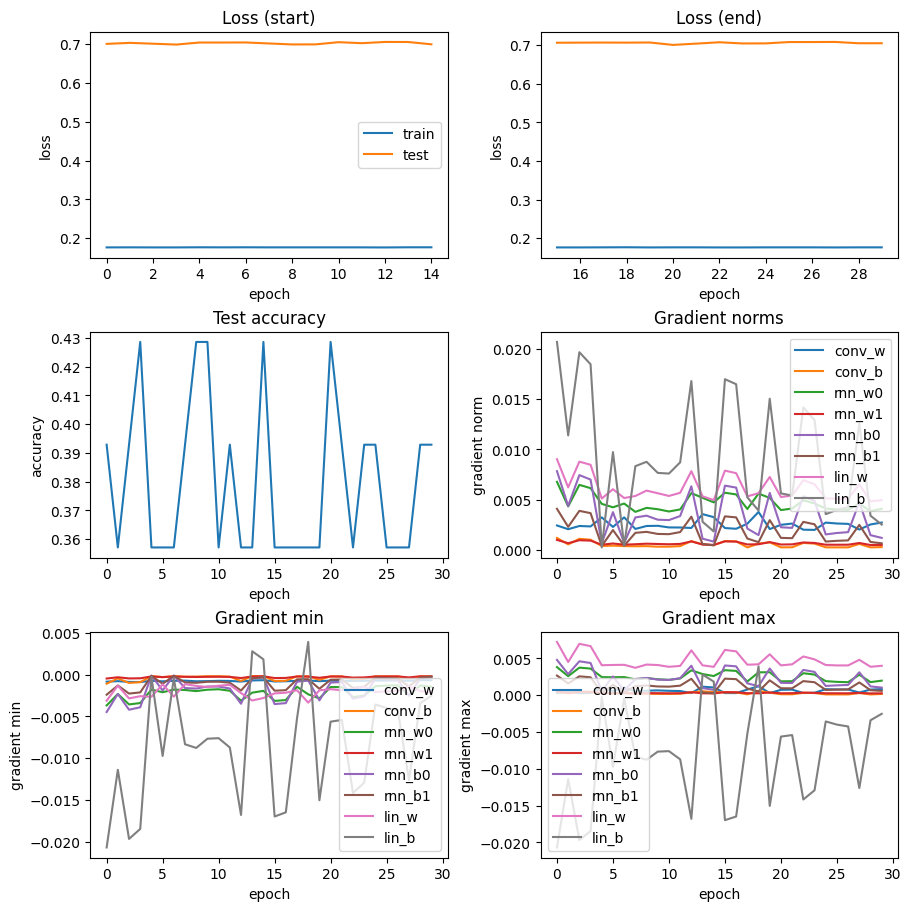

In [154]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 2, figsize=(9, 9), constrained_layout=True)
axs = axs.flatten()
ax_loss_1, ax_loss_2, ax_acc, ax_grad_norm, ax_grad_min, ax_grad_max = axs

ax_loss_1.plot(loss_history[:epochs//2], label="train")
ax_loss_1.plot(test_loss_history[:epochs//2], label="test")
ax_loss_1.set_title("Loss (start)")
ax_loss_1.set_xlabel("epoch")
ax_loss_1.set_ylabel("loss")
ax_loss_1.legend()

ax_loss_2.plot(list(range(epochs//2, epochs)), loss_history[epochs//2:], label="train")
ax_loss_2.plot(list(range(epochs//2, epochs)), test_loss_history[epochs//2:], label="test")
ax_loss_2.set_title("Loss (end)")
ax_loss_2.set_xlabel("epoch")
ax_loss_2.set_ylabel("loss")

ax_acc.plot(test_acc_history)
ax_acc.set_title("Test accuracy")
ax_acc.set_xlabel("epoch")
ax_acc.set_ylabel("accuracy")

for name, grads in grad_norm_history.items():
    ax_grad_norm.plot(grads, label=name)
ax_grad_norm.set_title("Gradient norms")
ax_grad_norm.set_xlabel("epoch")
ax_grad_norm.set_ylabel("gradient norm")
ax_grad_norm.legend()

for name, grads in grad_min_history.items():
    ax_grad_min.plot(grads, label=name)
ax_grad_min.set_title("Gradient min")
ax_grad_min.set_xlabel("epoch")
ax_grad_min.set_ylabel("gradient min")
ax_grad_min.legend()

for name, grads in grad_max_history.items():
    ax_grad_max.plot(grads, label=name)
ax_grad_max.set_title("Gradient max")
ax_grad_max.set_xlabel("epoch")
ax_grad_max.set_ylabel("gradient max")
ax_grad_max.legend()

plt.plot()

It looks like all the model weights approach zero pretty quickly, but the linear layer after the RNN is unstable. That must be why adding batch normalization after the RNN improved the performance.

After reducing the learning rate from 1e-2 to 4e-3, we can see the other layer weights are no longer so close to zero, but there is still instability.

Now let's repeat this with a couple of other architectures.

## Extra linear layer

In [155]:
def train_loop_with_gradients(dataloader, model, loss_fn, optimizer):
    avg_loss = 0.0
    grads = {
        "conv_w": 0.0,
        "conv_b": 0.0,
        "rnn_w0": 0.0,
        "rnn_w1": 0.0,
        "rnn_b0": 0.0,
        "rnn_b1": 0.0,
        "lin0_w": 0.0,
        "lin0_b": 0.0,
        "lin1_w": 0.0,
        "lin1_b": 0.0,
    }

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    for batch, (X, y) in enumerate(dataloader):

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss.item()

        grads["conv_w"] += model.conv.weight.grad.clone()
        grads["conv_b"] += model.conv.bias.grad.clone()

        grads["rnn_w0"] += model.rnn.all_weights[0][0].grad.clone()
        grads["rnn_w1"] += model.rnn.all_weights[0][1].grad.clone()
        grads["rnn_b0"] += model.rnn.all_weights[0][2].grad.clone()
        grads["rnn_b1"] += model.rnn.all_weights[0][3].grad.clone()

        grads["lin0_w"] += model.lin0.weight.grad.clone()
        grads["lin0_b"] += model.lin0.bias.grad.clone()

        grads["lin1_w"] += model.lin1.weight.grad.clone()
        grads["lin1_b"] += model.lin1.bias.grad.clone()

        if batch % 20 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    avg_loss /= size

    grads["conv_w"] /= num_batches
    grads["conv_b"] /= num_batches

    grads["rnn_w0"] /= num_batches
    grads["rnn_w1"] /= num_batches
    grads["rnn_b0"] /= num_batches
    grads["rnn_b1"] /= num_batches

    grads["lin0_w"] /= num_batches
    grads["lin0_b"] /= num_batches

    grads["lin1_w"] /= num_batches
    grads["lin1_b"] /= num_batches

    return {
        "loss": avg_loss,
        "grad": grads
    }


Epoch 1
-------------------------------
loss: 0.764840  [    4/  106]
loss: 0.661784  [   84/  106]
Test Error: 
 Accuracy: 60.7%, Avg loss: 0.681710 

Epoch 2
-------------------------------
loss: 0.757809  [    4/  106]
loss: 0.694946  [   84/  106]
Test Error: 
 Accuracy: 64.3%, Avg loss: 0.678616 

Epoch 3
-------------------------------
loss: 0.694795  [    4/  106]
loss: 0.668351  [   84/  106]
Test Error: 
 Accuracy: 64.3%, Avg loss: 0.680181 

Epoch 4
-------------------------------
loss: 0.694450  [    4/  106]
loss: 0.716731  [   84/  106]
Test Error: 
 Accuracy: 60.7%, Avg loss: 0.684475 

Epoch 5
-------------------------------
loss: 0.739629  [    4/  106]
loss: 0.694077  [   84/  106]
Test Error: 
 Accuracy: 60.7%, Avg loss: 0.685361 

Epoch 6
-------------------------------
loss: 0.714182  [    4/  106]
loss: 0.727622  [   84/  106]
Test Error: 
 Accuracy: 60.7%, Avg loss: 0.686225 

Epoch 7
-------------------------------
loss: 0.711480  [    4/  106]
loss: 0.693639  [ 

[]

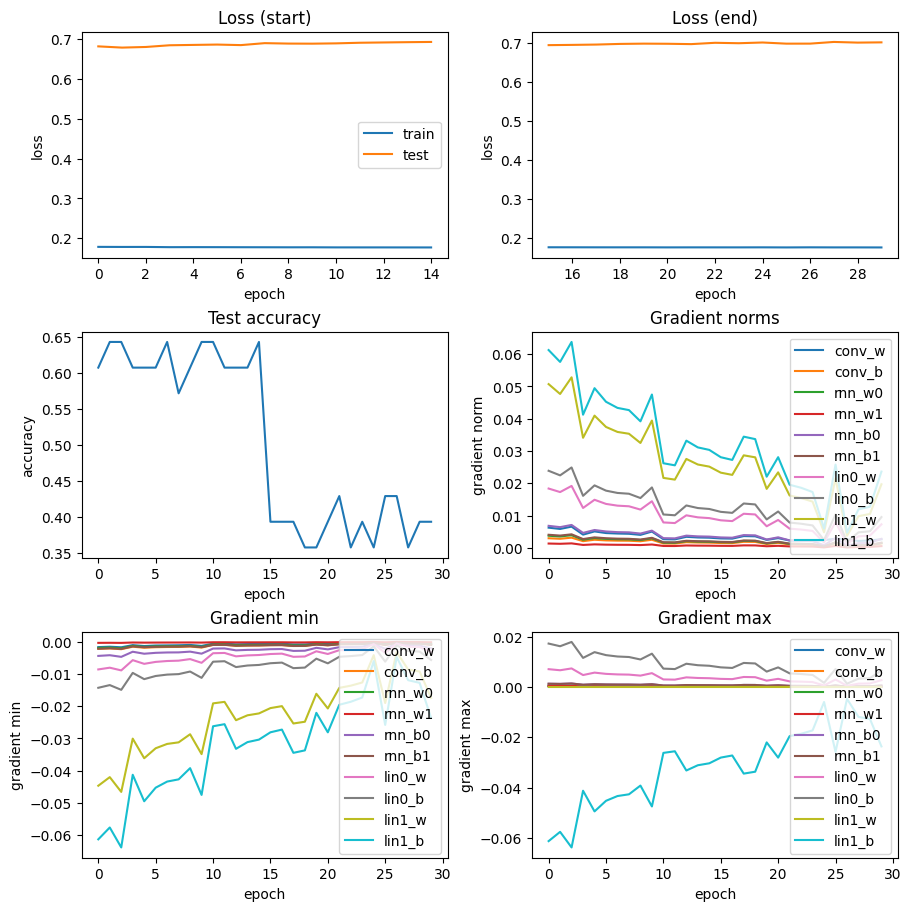

In [157]:
learning_rate = 4e-3
batch_size = 4
epochs = 30

model = ExtraLinearModel().to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

loss_history = []
test_loss_history = []
test_acc_history = []

grad_norm_history = {
    "conv_w": [],
    "conv_b": [],
    "rnn_w0": [],
    "rnn_w1": [],
    "rnn_b0": [],
    "rnn_b1": [],
    "lin0_w": [],
    "lin0_b": [],
    "lin1_w": [],
    "lin1_b": [],
}

grad_min_history = {
    "conv_w": [],
    "conv_b": [],
    "rnn_w0": [],
    "rnn_w1": [],
    "rnn_b0": [],
    "rnn_b1": [],
    "lin0_w": [],
    "lin0_b": [],
    "lin1_w": [],
    "lin1_b": [],
}

grad_max_history = {
    "conv_w": [],
    "conv_b": [],
    "rnn_w0": [],
    "rnn_w1": [],
    "rnn_b0": [],
    "rnn_b1": [],
    "lin0_w": [],
    "lin0_b": [],
    "lin1_w": [],
    "lin1_b": [],
}

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_metrics = train_loop_with_gradients(train_dataloader, model, loss_fn, optimizer)
    loss_history.append(train_metrics["loss"])
    for name, grads in train_metrics["grad"].items():
        grad_norm_history[name].append(torch.norm(grads))
        grad_min_history[name].append(torch.min(grads))
        grad_max_history[name].append(torch.max(grads))
    test_metrics = test_loop(test_dataloader, model, loss_fn)
    test_loss_history.append(test_metrics["loss"])
    test_acc_history.append(test_metrics["acc"])

print("Done!")

import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 2, figsize=(9, 9), constrained_layout=True)
axs = axs.flatten()
ax_loss_1, ax_loss_2, ax_acc, ax_grad_norm, ax_grad_min, ax_grad_max = axs

ax_loss_1.plot(loss_history[:epochs//2], label="train")
ax_loss_1.plot(test_loss_history[:epochs//2], label="test")
ax_loss_1.set_title("Loss (start)")
ax_loss_1.set_xlabel("epoch")
ax_loss_1.set_ylabel("loss")
ax_loss_1.legend()

ax_loss_2.plot(list(range(epochs//2, epochs)), loss_history[epochs//2:], label="train")
ax_loss_2.plot(list(range(epochs//2, epochs)), test_loss_history[epochs//2:], label="test")
ax_loss_2.set_title("Loss (end)")
ax_loss_2.set_xlabel("epoch")
ax_loss_2.set_ylabel("loss")

ax_acc.plot(test_acc_history)
ax_acc.set_title("Test accuracy")
ax_acc.set_xlabel("epoch")
ax_acc.set_ylabel("accuracy")

for name, grads in grad_norm_history.items():
    ax_grad_norm.plot(grads, label=name)
ax_grad_norm.set_title("Gradient norms")
ax_grad_norm.set_xlabel("epoch")
ax_grad_norm.set_ylabel("gradient norm")
ax_grad_norm.legend()

for name, grads in grad_min_history.items():
    ax_grad_min.plot(grads, label=name)
ax_grad_min.set_title("Gradient min")
ax_grad_min.set_xlabel("epoch")
ax_grad_min.set_ylabel("gradient min")
ax_grad_min.legend()

for name, grads in grad_max_history.items():
    ax_grad_max.plot(grads, label=name)
ax_grad_max.set_title("Gradient max")
ax_grad_max.set_xlabel("epoch")
ax_grad_max.set_ylabel("gradient max")
ax_grad_max.legend()

plt.plot()

Still, the post-RNN linear layers struggle to converge while the other layer gradients are very close to zero.

Perhaps a layer-wise adaptive learning rate scheduler like Adam might be useful here.

## Batch normalized architecture

In [158]:
def train_loop_with_gradients(dataloader, model, loss_fn, optimizer):
    avg_loss = 0.0
    grads = {
        "conv_w": 0.0,
        "conv_b": 0.0,
        "rnn_w0": 0.0,
        "rnn_w1": 0.0,
        "rnn_b0": 0.0,
        "rnn_b1": 0.0,
        "lin_w": 0.0,
        "lin_b": 0.0,
    }

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    for batch, (X, y) in enumerate(dataloader):

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss.item()

        grads["conv_w"] += model.conv.weight.grad.clone()
        grads["conv_b"] += model.conv.bias.grad.clone()

        grads["rnn_w0"] += model.rnn.all_weights[0][0].grad.clone()
        grads["rnn_w1"] += model.rnn.all_weights[0][1].grad.clone()
        grads["rnn_b0"] += model.rnn.all_weights[0][2].grad.clone()
        grads["rnn_b1"] += model.rnn.all_weights[0][3].grad.clone()

        grads["lin_w"] += model.lin.weight.grad.clone()
        grads["lin_b"] += model.lin.bias.grad.clone()

        if batch % 20 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    avg_loss /= size

    grads["conv_w"] /= num_batches
    grads["conv_b"] /= num_batches

    grads["rnn_w0"] /= num_batches
    grads["rnn_w1"] /= num_batches
    grads["rnn_b0"] /= num_batches
    grads["rnn_b1"] /= num_batches

    grads["lin_w"] /= num_batches
    grads["lin_b"] /= num_batches

    return {
        "loss": avg_loss,
        "grad": grads
    }


Epoch 1
-------------------------------
loss: 0.647590  [   32/  106]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.675676 

Epoch 2
-------------------------------
loss: 0.663542  [   32/  106]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.674837 

Epoch 3
-------------------------------
loss: 0.705366  [   32/  106]
Test Error: 
 Accuracy: 53.8%, Avg loss: 0.677024 

Epoch 4
-------------------------------
loss: 0.632473  [   32/  106]
Test Error: 
 Accuracy: 53.8%, Avg loss: 0.676093 

Epoch 5
-------------------------------
loss: 0.600176  [   32/  106]
Test Error: 
 Accuracy: 53.8%, Avg loss: 0.673251 

Epoch 6
-------------------------------
loss: 0.682150  [   32/  106]
Test Error: 
 Accuracy: 53.8%, Avg loss: 0.660312 

Epoch 7
-------------------------------
loss: 0.655418  [   32/  106]
Test Error: 
 Accuracy: 53.8%, Avg loss: 0.658696 

Epoch 8
-------------------------------
loss: 0.648790  [   32/  106]
Test Error: 
 Accuracy: 53.8%, Avg loss: 0.658002 

Epoch 9
----------------

[]

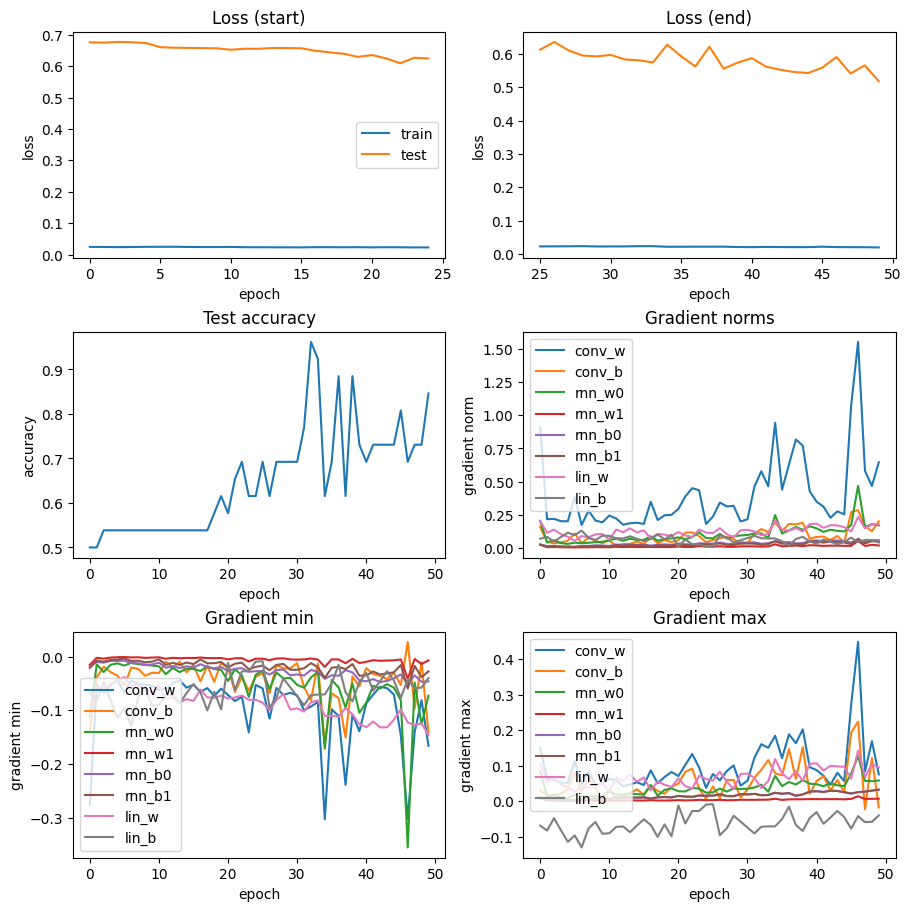

In [168]:
learning_rate = 1e-2
batch_size = 4
epochs = 50

model = BatchNormAfterRnnModel().to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

loss_history = []
test_loss_history = []
test_acc_history = []

grad_norm_history = {
    "conv_w": [],
    "conv_b": [],
    "rnn_w0": [],
    "rnn_w1": [],
    "rnn_b0": [],
    "rnn_b1": [],
    "lin_w": [],
    "lin_b": [],
}

grad_min_history = {
    "conv_w": [],
    "conv_b": [],
    "rnn_w0": [],
    "rnn_w1": [],
    "rnn_b0": [],
    "rnn_b1": [],
    "lin_w": [],
    "lin_b": [],
}

grad_max_history = {
    "conv_w": [],
    "conv_b": [],
    "rnn_w0": [],
    "rnn_w1": [],
    "rnn_b0": [],
    "rnn_b1": [],
    "lin_w": [],
    "lin_b": [],
}

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_metrics = train_loop_with_gradients(train_dataloader, model, loss_fn, optimizer)
    loss_history.append(train_metrics["loss"])
    for name, grads in train_metrics["grad"].items():
        grad_norm_history[name].append(torch.norm(grads))
        grad_min_history[name].append(torch.min(grads))
        grad_max_history[name].append(torch.max(grads))
    test_metrics = test_loop(test_dataloader, model, loss_fn)
    test_loss_history.append(test_metrics["loss"])
    test_acc_history.append(test_metrics["acc"])

print("Done!")

fig, axs = plt.subplots(3, 2, figsize=(9, 9), constrained_layout=True)
axs = axs.flatten()
ax_loss_1, ax_loss_2, ax_acc, ax_grad_norm, ax_grad_min, ax_grad_max = axs

ax_loss_1.plot(loss_history[:epochs//2], label="train")
ax_loss_1.plot(test_loss_history[:epochs//2], label="test")
ax_loss_1.set_title("Loss (start)")
ax_loss_1.set_xlabel("epoch")
ax_loss_1.set_ylabel("loss")
ax_loss_1.legend()

ax_loss_2.plot(list(range(epochs//2, epochs)), loss_history[epochs//2:], label="train")
ax_loss_2.plot(list(range(epochs//2, epochs)), test_loss_history[epochs//2:], label="test")
ax_loss_2.set_title("Loss (end)")
ax_loss_2.set_xlabel("epoch")
ax_loss_2.set_ylabel("loss")

ax_acc.plot(test_acc_history)
ax_acc.set_title("Test accuracy")
ax_acc.set_xlabel("epoch")
ax_acc.set_ylabel("accuracy")

for name, grads in grad_norm_history.items():
    ax_grad_norm.plot(grads, label=name)
ax_grad_norm.set_title("Gradient norms")
ax_grad_norm.set_xlabel("epoch")
ax_grad_norm.set_ylabel("gradient norm")
ax_grad_norm.legend()

for name, grads in grad_min_history.items():
    ax_grad_min.plot(grads, label=name)
ax_grad_min.set_title("Gradient min")
ax_grad_min.set_xlabel("epoch")
ax_grad_min.set_ylabel("gradient min")
ax_grad_min.legend()

for name, grads in grad_max_history.items():
    ax_grad_max.plot(grads, label=name)
ax_grad_max.set_title("Gradient max")
ax_grad_max.set_xlabel("epoch")
ax_grad_max.set_ylabel("gradient max")
ax_grad_max.legend()

plt.plot()

With batch normalization after the RNN layer, we see that the convolutional layers are actually forced into doing something!

This is likely because the RNN normally squashes all the activations from the convolutional layers so their gradients with respect to the loss are tiny. The model tries to compensate by adjusting the linear layer weights at the end, whereas it should be adjusting the convolutional layer weights to learn spatial features.

The noisiness of the graph is not improved by reducing the learning rate, and in fact doing so reduces the accuracy. We train for 50 epochs instead of 30 to get a better sense of how the model is progressing. Accuracy generally goes up, but it is very spiky.

Now let's try with the "batch norm both" model.

Epoch 1
-------------------------------
loss: 0.568526  [    4/  106]
loss: 1.022829  [   84/  106]
Test Error: 
 Accuracy: 57.1%, Avg loss: 0.756305 

Epoch 2
-------------------------------
loss: 0.628823  [    4/  106]
loss: 0.840780  [   84/  106]
Test Error: 
 Accuracy: 46.4%, Avg loss: 0.801090 

Epoch 3
-------------------------------
loss: 1.119064  [    4/  106]
loss: 0.782298  [   84/  106]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.699592 

Epoch 4
-------------------------------
loss: 1.040378  [    4/  106]
loss: 0.649480  [   84/  106]
Test Error: 
 Accuracy: 53.6%, Avg loss: 0.712226 

Epoch 5
-------------------------------
loss: 0.720795  [    4/  106]
loss: 0.767484  [   84/  106]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.699566 

Epoch 6
-------------------------------
loss: 0.601523  [    4/  106]
loss: 0.564577  [   84/  106]
Test Error: 
 Accuracy: 57.1%, Avg loss: 0.683016 

Epoch 7
-------------------------------
loss: 0.770207  [    4/  106]
loss: 0.547301  [ 

[]

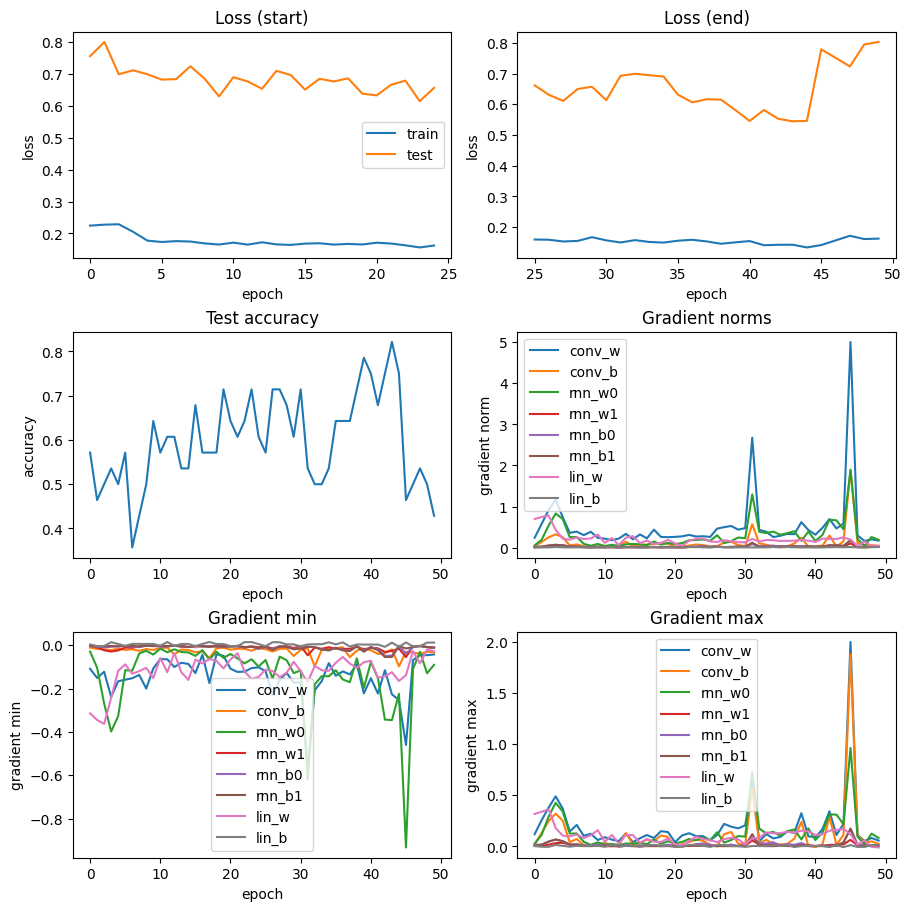

In [166]:
learning_rate = 1e-2
batch_size = 4
epochs = 50

model = BatchNormBothModel().to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

loss_history = []
test_loss_history = []
test_acc_history = []

grad_norm_history = {
    "conv_w": [],
    "conv_b": [],
    "rnn_w0": [],
    "rnn_w1": [],
    "rnn_b0": [],
    "rnn_b1": [],
    "lin_w": [],
    "lin_b": [],
}

grad_min_history = {
    "conv_w": [],
    "conv_b": [],
    "rnn_w0": [],
    "rnn_w1": [],
    "rnn_b0": [],
    "rnn_b1": [],
    "lin_w": [],
    "lin_b": [],
}

grad_max_history = {
    "conv_w": [],
    "conv_b": [],
    "rnn_w0": [],
    "rnn_w1": [],
    "rnn_b0": [],
    "rnn_b1": [],
    "lin_w": [],
    "lin_b": [],
}

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_metrics = train_loop_with_gradients(train_dataloader, model, loss_fn, optimizer)
    loss_history.append(train_metrics["loss"])
    for name, grads in train_metrics["grad"].items():
        grad_norm_history[name].append(torch.norm(grads))
        grad_min_history[name].append(torch.min(grads))
        grad_max_history[name].append(torch.max(grads))
    test_metrics = test_loop(test_dataloader, model, loss_fn)
    test_loss_history.append(test_metrics["loss"])
    test_acc_history.append(test_metrics["acc"])

print("Done!")

fig, axs = plt.subplots(3, 2, figsize=(9, 9), constrained_layout=True)
axs = axs.flatten()
ax_loss_1, ax_loss_2, ax_acc, ax_grad_norm, ax_grad_min, ax_grad_max = axs

ax_loss_1.plot(loss_history[:epochs//2], label="train")
ax_loss_1.plot(test_loss_history[:epochs//2], label="test")
ax_loss_1.set_title("Loss (start)")
ax_loss_1.set_xlabel("epoch")
ax_loss_1.set_ylabel("loss")
ax_loss_1.legend()

ax_loss_2.plot(list(range(epochs//2, epochs)), loss_history[epochs//2:], label="train")
ax_loss_2.plot(list(range(epochs//2, epochs)), test_loss_history[epochs//2:], label="test")
ax_loss_2.set_title("Loss (end)")
ax_loss_2.set_xlabel("epoch")
ax_loss_2.set_ylabel("loss")

ax_acc.plot(test_acc_history)
ax_acc.set_title("Test accuracy")
ax_acc.set_xlabel("epoch")
ax_acc.set_ylabel("accuracy")

for name, grads in grad_norm_history.items():
    ax_grad_norm.plot(grads, label=name)
ax_grad_norm.set_title("Gradient norms")
ax_grad_norm.set_xlabel("epoch")
ax_grad_norm.set_ylabel("gradient norm")
ax_grad_norm.legend()

for name, grads in grad_min_history.items():
    ax_grad_min.plot(grads, label=name)
ax_grad_min.set_title("Gradient min")
ax_grad_min.set_xlabel("epoch")
ax_grad_min.set_ylabel("gradient min")
ax_grad_min.legend()

for name, grads in grad_max_history.items():
    ax_grad_max.plot(grads, label=name)
ax_grad_max.set_title("Gradient max")
ax_grad_max.set_xlabel("epoch")
ax_grad_max.set_ylabel("gradient max")
ax_grad_max.legend()

plt.plot()

# Conclusion

We have tried several ways to improve the classification accuracy. None of them have proved a silver bullet, but we did have modest success with batch normalization, particularly after the RNN part of the model. It is unclear whether collecting more data would improve model performance, but it would be prudent to do so anyway. We could assess this better if we tracked training accuracy in addition to test accuracy.

Further experiments would benefit from having a more robust experiment tracking framework, which gives us easier access to relevant information such as model weights and gradients.